In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import fastai
import fastai.dataset
import pydicom
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from fastai.conv_learner import *
from fastai.dataset import *

In [3]:
torch.backends.cudnn.benchmark=True

## Parsing and Drawing Functions

In [29]:
def isdicom(fn):
    if fn.endswith('.dcm'):
        return True
    # Dicom signature from the dicom spec.
    with open(fn) as fh:
        fh.seek(0x80)
        return fh.read(4)=='DICM'


def open_image(fn):
    """ Modifying fastai's open_image to allow dicom files to be read.
    from https://www.kaggle.com/dovgro/fastai-exploration

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn) and not str(fn).startswith("http"):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn) and not str(fn).startswith("http"):
        raise OSError('Is a directory: {}'.format(fn))
    elif isdicom(fn):
        slice = pydicom.read_file(fn)
        if slice.PhotometricInterpretation.startswith('MONOCHROME'):
            # Make a fake RGB image
            im = np.stack([slice.pixel_array]*3,-1)
            return im / ((1 << slice.BitsStored)-1)
        else:
            # No support for RGB yet, as it involves various color spaces.
            # It shouldn't be too difficult to add though, if needed.
            raise OSError('Unsupported DICOM image with PhotometricInterpretation=={}'.format(slice.PhotometricInterpretation))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
        #return res
        try:
            if str(fn).startswith("http"):
                req = urllib.urlopen(str(fn))
                image = np.asarray(bytearray(req.read()), dtype="uint8")
                im = cv2.imdecode(image, flags).astype(np.float32)/255
            else:
                im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

fastai.dataset.isdicom=isdicom
fastai.dataset.pydicom=pydicom
fastai.dataset.open_image=open_image

In [32]:
def hw_bb(row): return np.array([row['y'], row['x'], row['height']+row['y'], row['width']+row['x']])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def parse_data(df):
    
    parsed = collections.defaultdict(lambda:{'dicom': None,    
        'label': None,
        'boxes': []})
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        parsed[pid]['dicom'] = str(f'{pid}.dcm')
        parsed[pid]['label'] = row['Target']
        parsed[pid]['boxes'].append(hw_bb(row))

    return parsed


def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[-2:]-x[:2]), reverse=True)
    return [b[0]]


def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax


def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
    
def draw_rect(ax, b, col = 'white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor = col, lw=2))
    draw_outline(patch,4)
    
    
def draw_text(ax, xy, txt, sz=14, col='white'):
    text = ax.text(*xy, txt, verticalalignment='top', color=col, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
    
def draw_im(im, ann, ax=None):
    ax = show_img(im, figsize=(16,8), ax =ax)
    l = ann['label']
    for b in ann['boxes']:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], l, sz=16)  
        
        
def draw_idx(i, ax=None):
    im_a = parsed_lrg_p[i]
    im = open_image('path/to/training/images/'+parsed[i]['dicom'])
    draw_im(im, im_a, ax=ax)

## Data Pre-procesing

In [33]:
PATH = Path('path/to/data')

In [34]:
label_csv = PATH/'stage_2_train_labels.csv'
df = pd.read_csv(label_csv)
df1 = df.loc[df['Target'] == 1]

In [35]:
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [36]:
df1.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [37]:
parsed1s = parse_data(df1)
len(parsed1s)

6012

In [38]:
cats = {0: 'normal', 1: 'pneumonia'}

In [39]:
parsed_lrg1s = {a: {'dicom': b['dicom'],
                  'boxes': get_lrg(b['boxes'])} for a, b in parsed1s.items()}

In [40]:
parsed_lrg1s["00436515-870c-4b36-a041-de91049b9ab4"]

{'dicom': '00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'boxes': [array([152., 562., 605., 818.])]}

In [41]:
(PATH/'tmp').mkdir(exist_ok=True)
BB1 = PATH/'tmp/bb1.csv'

In [42]:
df = pd.DataFrame({'fn': [parsed_lrg1s[o]['dicom'] for o in parsed_lrg1s],
                   'bbox': [' '.join(str(int(p)) for p in parsed_lrg1s[o]['boxes'][0]) for o in parsed_lrg1s]})

In [43]:
df[:5]

,fn,bbox
0,00436515-870c-4b36-a041-de91049b9ab4.dcm,152 562 605 818
1,00704310-78a8-4b38-8475-49f4573b2dbb.dcm,575 695 712 857
2,00aecb01-a116-45a2-956c-08d2fa55433f.dcm,299 547 464 666
3,00c0b293-48e7-4e16-ac76-9269ba535a62.dcm,511 650 795 856
4,00f08de1-517e-4652-a04f-d1dc9ee48593.dcm,275 571 751 801


In [44]:
df.to_csv(BB1, index=False)

In [45]:
f_model = resnet34
sz=224
bs=64

## Transformations

In [46]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, 'stage_2_train_images', BB1, tfms=tfms, bs=bs, continuous=True)

In [47]:
x,y=next(iter(md.aug_dl))

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(to_np(y[i]))
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## BBox Training

In [25]:
custom_head_reg = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=custom_head_reg)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()
learn2 = ConvLearner.pretrained(f_model, md2, custom_head=custom_head_reg)
learn2.opt_fn = optim.Adam
learn2.crit = nn.L1Loss()

In [27]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

 78%|███████▊  | 59/76 [02:30<00:40,  2.36s/it, loss=335]

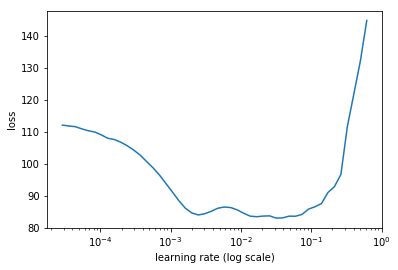

In [62]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [63]:
lr = 1e-3

In [64]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      38.454875  33.01043  
    1      32.710737  30.500372 
    2      30.547625  30.414171 


[array([30.41417])]

In [65]:
lrs = np.array([lr/100,lr/10,lr])

In [66]:
learn.freeze_to(-2)

epoch      trn_loss   val_loss   
    0      68.181184  1530020303877.1116


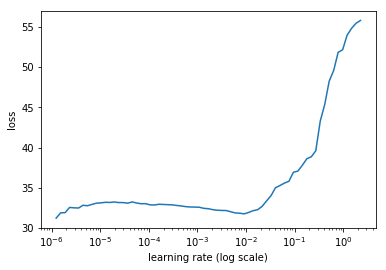

In [67]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [68]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      28.034076  26.758608 
    1      25.632572  26.863729 
    2      22.451043  25.154231 


[array([25.15423])]

In [69]:
learn.freeze_to(-3)

In [70]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss   
    0      23.787794  24.845712 
    1      20.634952  24.060993 


[array([24.06099])]

In [71]:
learn.save('box1')

In [28]:
learn.load('box1')

In [81]:
x,y = next(iter(md2.val_dl))
learn2.model.eval()
preds = learn2.predict()

In [82]:
len(preds)

5336

## Drawing First Results

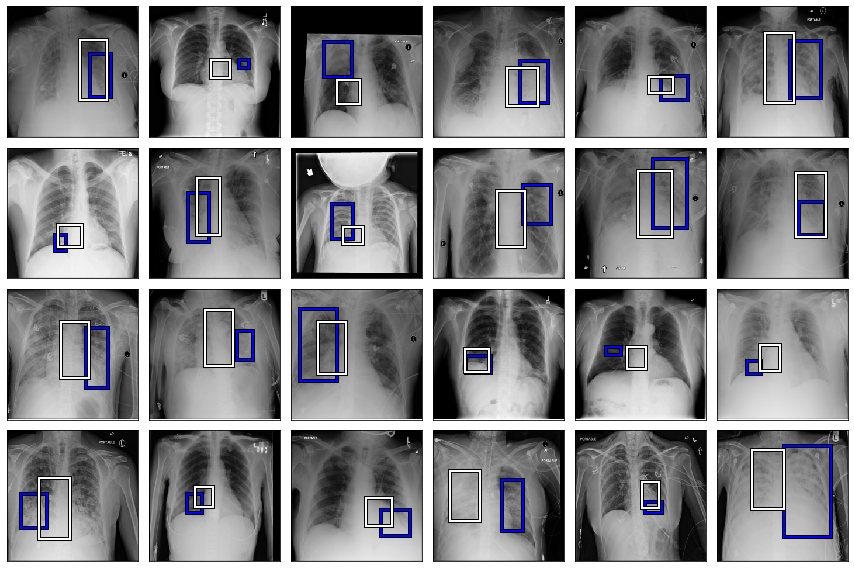

In [81]:
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    tb = bb_hw(to_np(y[i]))
    ax = show_img(ima, ax=ax)
    draw_rect(ax,tb, col='blue')
    draw_rect(ax, b)
plt.tight_layout()

### Some Aditional Training

epoch      trn_loss   val_loss   
    0      61.800764  1139597136963703.2


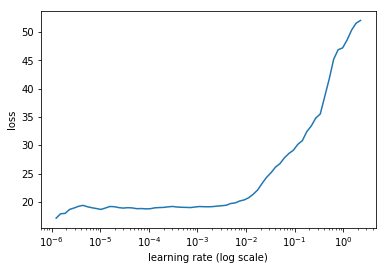

In [82]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [83]:
learn.unfreeze()

In [84]:
lrs = np.array([lr/100,lr/10,lr])

In [85]:
learn.fit(lr,3,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   
    0      26.534125  24.802136 
    1      25.938985  25.077765 
    2      23.316396  22.458866 
    3      24.48449   27.415151 
    4      23.449735  24.338139 
    5      21.886192  22.1592   
    6      20.270027  21.338919 


[array([21.33892])]

### Model is saved

In [55]:
learn.save('box1')

In [28]:
learn.load('box1')

In [36]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = learn.predict()

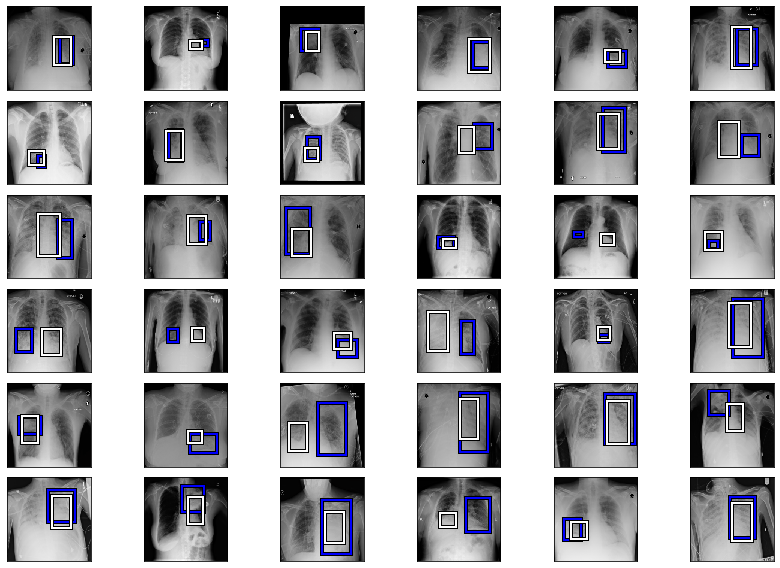

In [30]:
fig, axes = plt.subplots(6, 6, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    tb = bb_hw(to_np(y[i]))
    ax = show_img(ima, ax=ax)
    draw_rect(ax,tb, col='blue')
    draw_rect(ax, b)
plt.tight_layout()

In [108]:
def iou(box1, box2):
    """ Intersection over union metric.
    from https://www.kaggle.com/chenyc15/mean-average-precision-metric
    """
    x11, y11, w1, h1 = box1
    x21, y21, w2, h2 = box2
    assert w1 * h1 >= 0
    assert w2 * h2 >= 0
    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union
    

In [89]:
all_batches = []

In [100]:
for i in range(len(md2.val_ds)):
    all_boxes.append(md2.val_ds[i][1])

In [90]:
batch_iterator = (iter(md2.val_dl))

In [91]:
for i in range(19):
    batch = next(batch_iterator)
    all_batches.append(batch[1][:])

In [141]:
for i in all_batches:
    for box in i:
        all_boxes.append(box.cpu().numpy())

In [150]:
true_boxes=(np.asarray(all_boxes))

In [177]:
accuracy = 0

In [178]:
for i in range(len(preds)):
    accuracy += iou(true_boxes[i], preds[i])
mean_accuracy = accuracy/(len(preds))

In [179]:
mean_accuracy

0.5040788048220667